In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
class_names = ['auto_test', 'test', 'train', 'val']
IMG_SIZE = 224

In [2]:
path = "data"

In [3]:
def get_data(path, class_name):
    data = []
    for i in range(0, 5):
        try:
            files = glob.glob(path+"/"+class_name+"/"+str(i)+"/*")
            for f in files:
                img = cv2.imread(f)
                img =  cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(np.array([np.array(img), i], dtype=object))
        except:
            pass
    np.random.shuffle(data)
    return data

In [4]:
train_data = get_data(path, "train")
train_data = np.array(train_data, dtype=object)
train_data.shape

(5778, 2)

In [5]:
test_data = get_data(path, "test")
data = get_data(path, "auto_test")

In [6]:
for x in  data:
    test_data.append(x)

In [7]:
test_data = np.array(test_data, dtype=object)
test_data.shape

(3182, 2)

In [8]:
np.random.shuffle(test_data)
test_data.shape

(3182, 2)

In [9]:
val_data = get_data(path, "val")
val_data = np.array(val_data, dtype=object)
val_data.shape

(826, 2)

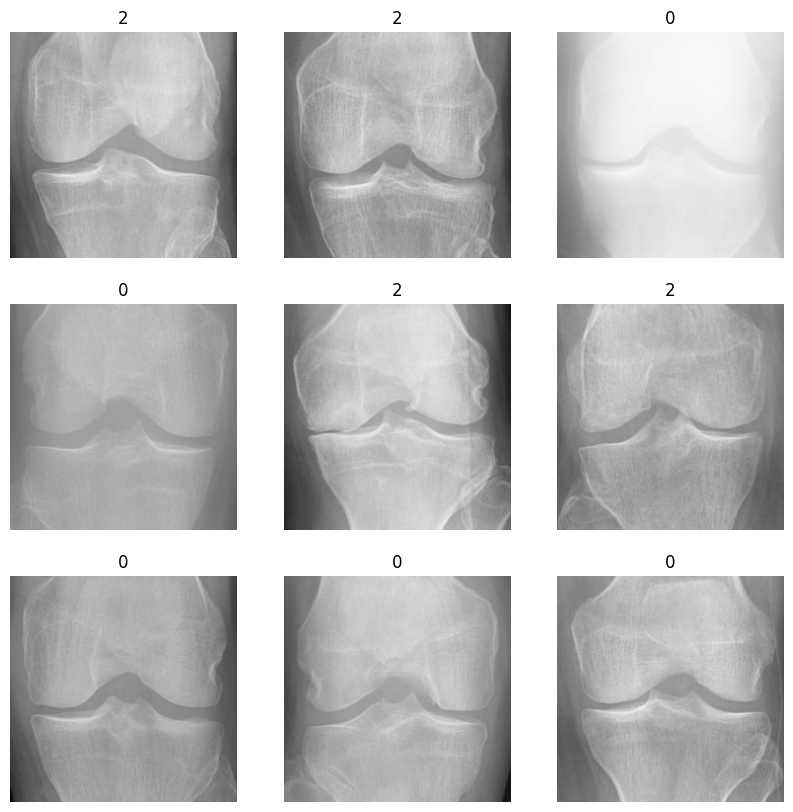

In [10]:
# Training data vizualization
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    val = np.random.randint(0, 5778)
    plt.imshow(train_data[val][0].astype("uint8"))
    plt.title(int(train_data[val][1]))
    plt.axis("off")

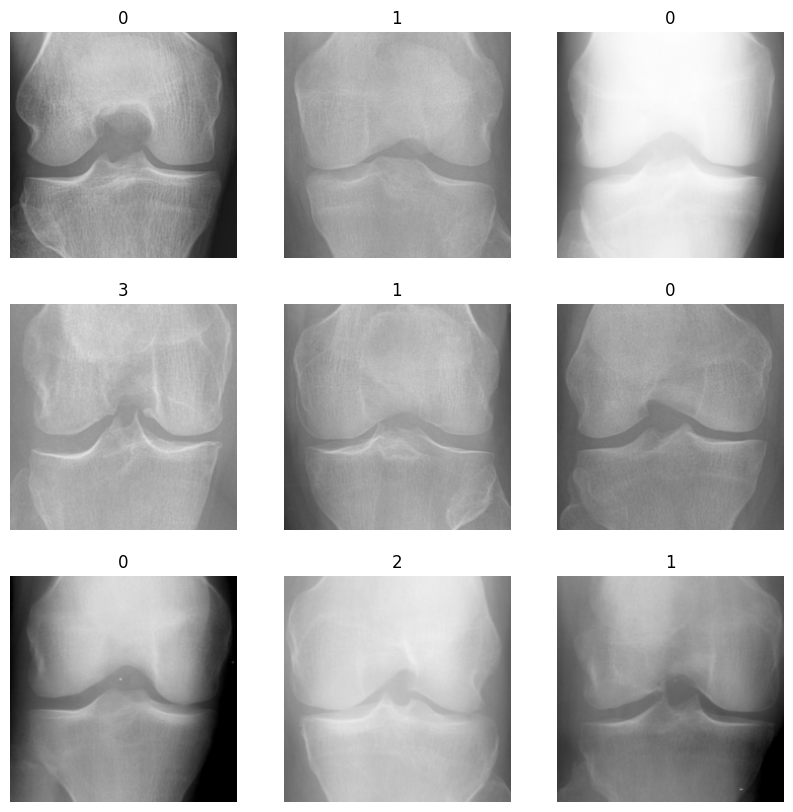

In [11]:
# Testing data vizualization
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    val = np.random.randint(0, 3182)
    plt.imshow(test_data[val][0].astype("uint8"))
    plt.title(test_data[val][1])
    plt.axis("off")

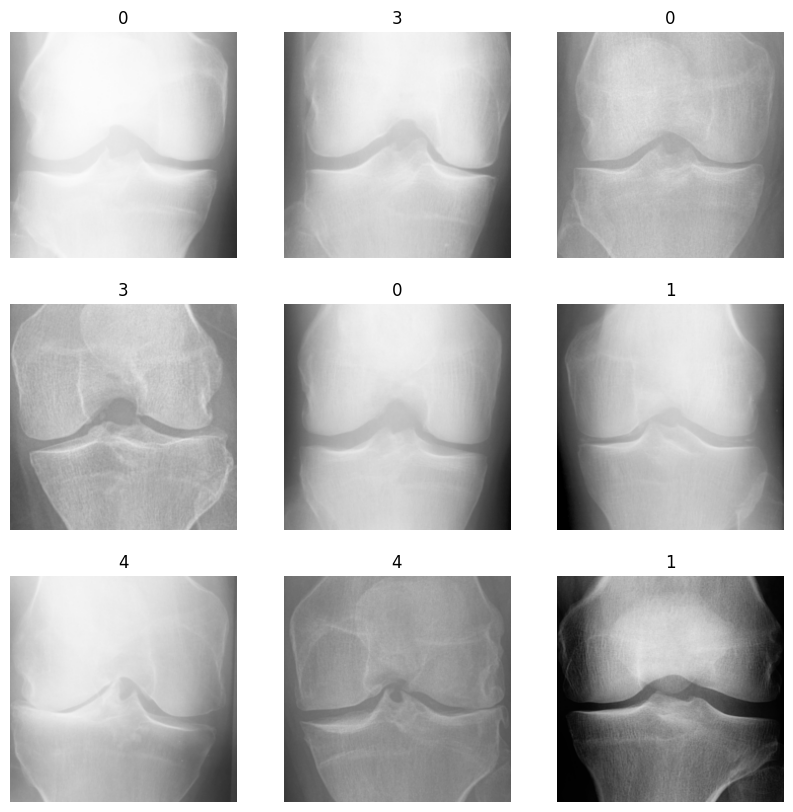

In [12]:
# Validation data vizualization
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    val = np.random.randint(0, 826)
    plt.imshow(val_data[val][0].astype("uint8"))
    plt.title(val_data[val][1])
    plt.axis("off")

In [13]:
train_x = []
train_y = []
length = train_data.shape[0]
for i in range(0, 5778):
    train_x.append(train_data[i][0])
    train_y.append(train_data[i][1])

In [14]:
import tensorflow as tf

In [15]:
train_x = np.array(train_x, ndmin=3)
train_y = np.array(train_y, ndmin=1)

In [16]:
train_x.shape, train_y.shape

((5778, 224, 224, 3), (5778,))

In [17]:
test_x = []
test_y = []
for i in range(test_data.shape[0]):
    test_x.append(test_data[i][0])
    test_y.append(test_data[i][1])
test_x = np.array(test_x, ndmin=3)
test_y = np.array(test_y, ndmin=1)

In [18]:
test_x.shape, test_y.shape

((3182, 224, 224, 3), (3182,))

In [19]:
val_x = []
val_y = []
for i in range(val_data.shape[0]):
    val_x.append(val_data[i][0])
    val_y.append(val_data[i][1])
val_x = np.array(val_x, ndmin=3)
val_y = np.array(val_y, ndmin=1)

In [20]:
val_x.shape, val_y.shape

((826, 224, 224, 3), (826,))

In [21]:
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0
val_x = val_x.astype("float32") / 255.0

In [22]:
val_x[0].shape

(224, 224, 3)

In [23]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.applications.vgg16 import VGG16

In [24]:
vgg = VGG16(include_top=False, weights="imagenet",input_shape= val_x[0].shape)
vgg.trainable = False

In [71]:
model = Sequential([
    vgg,
    Dropout(0.25),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(32, activation="relu"),
    Dense(5, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

In [72]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights='True',
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="squared_hinge", metrics=["binary_accuracy", "accuracy"])

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [74]:
from sklearn.preprocessing import LabelBinarizer

In [75]:
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
train_y.shape

(5778, 5)

In [76]:
lb = LabelBinarizer()
test_y = lb.fit_transform(test_y)
test_y.shape

(3182, 5)

In [77]:
lb = LabelBinarizer()
val_y = lb.fit_transform(val_y)
val_y.shape

(826, 5)

In [79]:
history = model.fit(train_x[0: 150] , train_y[0: 150] , epochs=2 , batch_size=32,
                    validation_data=(val_x,val_y), verbose=1)

Epoch 1/2
5/5 [==============================] - 165s 40s/step - loss: 1.4062 - binary_accuracy: 0.7240 - accuracy: 0.2733 - val_loss: 1.3482 - val_binary_accuracy: 0.7588 - val_accuracy: 0.3971
Epoch 2/2
5/5 [==============================] - 187s 44s/step - loss: 1.3705 - binary_accuracy: 0.7373 - accuracy: 0.3267 - val_loss: 1.3622 - val_binary_accuracy: 0.7588 - val_accuracy: 0.3971


In [33]:
test_pred = model.predict(test_x)

100/100 [==============================] - 676s 7s/step


In [35]:
import numpy as np

In [63]:
print(test_pred)

[[0.4464654  0.15749371 0.2780717  0.10362187 0.01434735]
 [0.486614   0.15571329 0.25209945 0.09574552 0.00982773]
 [0.4597773  0.17382634 0.24718945 0.10372227 0.01548475]
 ...
 [0.53177387 0.14553615 0.23701496 0.07951404 0.00616094]
 [0.3797544  0.16047756 0.2940127  0.14253423 0.02322106]
 [0.38903064 0.1684266  0.2830447  0.13566148 0.02383647]]


In [64]:
test_pred_y = []
test_true_y = []
for i in range(0, test_pred.shape[0]):
    test_pred_y.append(np.argmax(test_pred[i]))
    test_true_y.append(np.argmax(test_y[i]))

In [65]:
test_pred_y = np.array(test_pred_y)
test_true_y = np.array(test_true_y)

In [69]:
from sklearn.metrics import roc_auc_score

In [68]:
print(roc_auc_score(test_y, test_pred))

0.7135729697031503
